In [251]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [299]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

## Merge all tables

In [300]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')
df_merged = df_merged.rename(columns={'country_x': 'country_user', 'country_y': 'country_merchant'})
df = df_merged

In [301]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,country_user,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,...,Sweden,2022-08-10,0.426675,travel,France,0.581711,3,74.97,23,1
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,...,France,2024-05-22,0.729627,electronics,Germany,0.568933,2,56.92,23,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,...,Italy,2021-05-18,0.393848,gaming,Denmark,0.608070,5,98.93,75,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,...,Portugal,2021-09-05,0.393405,electronics,Portugal,0.592656,4,21.60,82,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,...,Austria,2023-06-01,0.524168,gaming,Spain,0.450223,4,60.61,82,0


In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   location                        500000 non-null  object        
 9   payment_method                  500000 non-null  object        
 10  is_international                500000 non-null  int64  

## Feature engineering
Created new columns:

(instead of `location`)
- `latitude`
- `longitude`

In [303]:
# Extract latitude and longitude into separate columns
df['latitude'] = df['location'].apply(lambda x: x['lat'])
df['longitude'] = df['location'].apply(lambda x: x['long'])
df.drop(columns=['location'], inplace=True)

In [ ]:
# df.to_csv("../data.csv")

- `hour`
- `day_of_week`
- `is_weekend`
- `month`

In [ ]:
# --------- Temporal data feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday

df['is_weekend'] = df['day_of_week'] >= 5
df['is_weekend'] = df['is_weekend'].astype(int)

df['days_since_signup'] = (df['timestamp'] - df['signup_date']).dt.total_seconds() / (3600 * 24)
df['month'] = df['timestamp'].dt.month

- `time_since_last_user_txn`
- `time_since_last_merchant_txn`
- `time_since_last_user_merchant`

In [258]:
# Time Since Last Transaction: User-level
df = df.sort_values(['user_id', 'timestamp'])
df['time_since_last_user_txn'] = (
    df.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

# Time Since Last Transaction: Merchant-level
df = df.sort_values(['merchant_id', 'timestamp'])
df['time_since_last_merchant_txn'] = (
    df.groupby('merchant_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

df['last_user_merchant_ts'] = df.groupby(['user_id', 'merchant_id'])['timestamp'].shift(1)
df['time_since_last_user_merchant'] = (df['timestamp'] - df['last_user_merchant_ts']).dt.total_seconds()

df.drop(columns=['last_user_merchant_ts'], inplace=True)

- `prev_latitude`
- `prev_longitude`
- `distance_from_last_txn_km`
-  `velocity_kmph`

In [259]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # distance in km

In [260]:
# --------- Geo-data feature engineering
df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Shift lat/lon to get last user's lat/lon
df['prev_latitude'] = df.groupby('user_id')['latitude'].shift(1)
df['prev_longitude'] = df.groupby('user_id')['longitude'].shift(1)

df['distance_from_last_txn_km'] = df.apply(
    lambda row: haversine_distance(row['prev_latitude'], row['prev_longitude'],
                                   row['latitude'], row['longitude']),
    axis=1
)

df['velocity_kmph'] = df.apply(
    lambda row: (
        row['distance_from_last_txn_km'] / (row['time_since_last_user_txn'] / 3600)
        if row['time_since_last_user_txn'] > 0 else np.nan
    ),
    axis=1
)

- `merchant_fraud_rate`

In [217]:
# # --------- Merchant data feature engineering
# merchant_fraud_rates = df.groupby('merchant_id')['is_fraud'].mean()
# df = df.merge(merchant_fraud_rates.rename('merchant_fraud_rate'), on='merchant_id')

- `rolling_fraud_count`
- `rolling_txn_count`
- `rolling_fraud_rate`

In [218]:
# parameters = {
#     "window" : '1h',
#     "zscore_threshold" : 3
# }

In [219]:
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df = df.sort_values(by=['country_merchant', 'timestamp'])
# df.set_index('timestamp', inplace=True)

# # 8-hour rolling stats

# df['rolling_fraud_count'] = (
#     df
#     .groupby('country_merchant')['is_fraud']
#     .rolling(window=parameters['window'])
#     .sum()
#     .reset_index(level=0, drop=True)
# )

# df['rolling_txn_count'] = (
#     df
#     .groupby('country_merchant')['is_fraud']
#     .rolling(window=parameters['window'])
#     .count()
#     .reset_index(level=0, drop=True)
# )

# # df['rolling_fraud_rate'] = (
# #     df['rolling_fraud_count'] / df['rolling_txn_count']
# # ).fillna(0)

# df = df.reset_index()

- `fraud_rate_change`
- `zscore_fraud_rate`
- `rolling_fraud_rate`

In [220]:
# df['fraud_rate_change'] = (
#     df.groupby('country_merchant')['rolling_fraud_rate'].diff()
# )

# # Z-score of fraud rate per country_merchant
# df['zscore_fraud_rate'] = (
#     df.groupby('country_merchant')['rolling_fraud_rate']
#     .transform(lambda x: zscore(x.fillna(0)))
# )

# # # Attack starts: rate jumps or statistical spike
# # df_merged['fraud_attack_start_flag'] = (
# #     # (df_merged['fraud_rate_change'] > 0.15) |
# #     (df_merged['zscore_fraud_rate'] > parameters['zscore_threshold'])
# # )

- `number_unique_devices_last_day`

In [261]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
tmp = df.groupby(['date', 'user_id'])['device'].nunique().reset_index()
tmp.rename(columns={'device': 'number_unique_devices_last_day'}, inplace=True)
df = df.merge(tmp, on=['date', 'user_id'], how='left')
df = df.drop(columns=["date"])

In [222]:
# df['datetime_hour'] = pd.to_datetime(df['timestamp']).dt.floor('H')  # Zaokrąglenie do pełnej godziny

# tmp = df.groupby(['datetime_hour', 'user_id'])['device'].nunique().reset_index()
# tmp.rename(columns={'device': 'number_unique_devices_last_hour'}, inplace=True)

# df = df.merge(tmp, on=['datetime_hour', 'user_id'], how='left')

- `number_unique_devices_per_month`

In [262]:
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

tmp = df.groupby(['year_month', 'user_id'])['device'].nunique().reset_index()
tmp.rename(columns={'device': 'number_unique_devices_per_month'}, inplace=True)

df = df.merge(tmp, on=['year_month', 'user_id'], how='left')
df = df.drop(columns=["year_month"])

- `number_unique_devices_per_year`

In [263]:
df['year'] = df['timestamp'].dt.year

tmp = df.groupby(['year', 'user_id'])['device'].nunique().reset_index()
tmp.rename(columns={'device': 'number_unique_devices_per_year'}, inplace=True)

df = df.merge(tmp, on=['year', 'user_id'], how='left')
df = df.drop(columns=["year"])

In [225]:
# df[["date", "user_id", "device", "number_unique_devices_last_day", "number_unique_devices_per_month", "number_unique_devices_per_year"]]

In [226]:
# df[df["user_id"]=="U00001"][["date", "month", "user_id", "device", "number_unique_devices_last_day", "number_unique_devices_per_month", "number_unique_devices_per_year", "is_fraud"]].sort_values(by="date")

Checking the acumulated-device-number features:

In [227]:
for val in [int(x) for x in sorted(df["number_unique_devices_last_day"].unique())]:
    uniqdev = df[df["number_unique_devices_last_day"]==val]["is_fraud"]
    print(f"Number of frauds for {val} devices per day: {sum(uniqdev)}\tPercentage of frauds:{sum(uniqdev)/len(uniqdev): .3f}.")

Number of frauds for 1 devices per day: 41444	Percentage of frauds: 0.085.
Number of frauds for 2 devices per day: 963	Percentage of frauds: 0.085.
Number of frauds for 3 devices per day: 4	Percentage of frauds: 0.060.


In [228]:
# for val in [int(x) for x in sorted(df["number_unique_devices_per_month"].unique())]:
#     uniqdev = df[df["number_unique_devices_per_month"]==val]["is_fraud"]
#     print(f"Number of frauds for {val} devices per month: {sum(uniqdev)}\tPercentage of frauds:{sum(uniqdev)/len(uniqdev): .3f}.")

In [229]:
for val in [int(x) for x in sorted(df["number_unique_devices_per_year"].unique())]:
    uniqdev = df[df["number_unique_devices_per_year"]==val]["is_fraud"]
    print(f"Number of frauds for {val} devices per year: {sum(uniqdev)}\tPercentage of frauds:{sum(uniqdev)/len(uniqdev): .3f}.")

Number of frauds for 1 devices per year: 11	Percentage of frauds: 0.076.
Number of frauds for 2 devices per year: 1279	Percentage of frauds: 0.084.
Number of frauds for 3 devices per year: 41121	Percentage of frauds: 0.085.


- `expenses_to_isntallment_ratio`

In [264]:
df["expenses_to_isntallment_ratio"] = df["sum_of_monthly_expenses"] / df["sum_of_monthly_installments"]

- `avg_daily_amount`
- `percent_change_from_avg_daily_transaction_amount` = (`amount` - `avg_daily_amount`) / `avg_daily_amount`
- `percent_diff_trans_amt_vs_merch_avg_amt` = (`amount` - `avg_transaction_amount`) / `avg_transaction_amount`

In [265]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

tmp = df.groupby(['date', 'user_id'])['amount'].mean().reset_index()
tmp.rename(columns={'amount': 'avg_daily_amount'}, inplace=True)

df = df.merge(tmp, on=['date', 'user_id'], how='left')
df = df.drop(columns=["date"])

In [266]:
df["percent_change_from_avg_daily_transaction_amount"] = (df["amount"]-df["avg_daily_amount"])/df["avg_daily_amount"]

In [267]:
df["percent_diff_trans_amt_vs_merch_avg_amt"] = (df["amount"]-df["avg_transaction_amount"])/df["avg_transaction_amount"]

TODO:
- tx_amount/sum_of_monthly_expenses
- std_dev_amount_of_tx_last_day
- (!) merchanci albo kraje merchantow sa atakowane w konkretnych czasach?

- Z-scores

In [268]:
import pandas as pd
from scipy.stats import zscore
from datetime import timedelta

df_tmp = df
df_tmp['timestamp'] = pd.to_datetime(df_tmp['timestamp'])
transactions_df = df_tmp.sort_values('timestamp')

frauds = transactions_df[transactions_df['is_fraud'] == 1]
frauds.set_index('timestamp', inplace=True)

# rolling window 28 days
rolling_data = frauds['amount'].rolling('1D').agg(['sum', 'count'])

z_scores = []

transactions_df = transactions_df.sort_values('timestamp')
for idx, row in transactions_df.iterrows():
    current_time = row['timestamp']
    current_amount = row['amount']
    
    frauds_last_28d = rolling_data[(rolling_data.index < current_time) & (rolling_data.index >= current_time - timedelta(days=1))]
    
    # count z-score for 5 frauds per window
    if len(frauds_last_28d) >= 5:
        fraud_amounts = frauds_last_28d['sum'].tolist() + [current_amount]
        z = zscore(fraud_amounts)[-1]
    else:
        z = 0  # Za mało danych
    
    z_scores.append(z)

transactions_df['z_score_vs_fraud_1d'] = z_scores
transactions_df

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,distance_from_last_txn_km,velocity_kmph,number_unique_devices_last_day,number_unique_devices_per_month,number_unique_devices_per_year,expenses_to_isntallment_ratio,avg_daily_amount,percent_change_from_avg_daily_transaction_amount,percent_diff_trans_amt_vs_merch_avg_amt,z_score_vs_fraud_1d
109570,TX497783,2022-01-01 00:06:00,U04367,M0197,41.78,in-store,EUR,Android,mobile_payment,1,...,NaN,NaN,1,2,3,2.330988,41.78,0.000000,-0.509970,0.000000
56264,TX466651,2022-01-01 00:12:00,U02226,M0496,160.69,in-store,EUR,Android,bank_transfer,1,...,NaN,NaN,1,1,3,15.121576,160.69,0.000000,0.702405,0.000000
199136,TX087684,2022-01-01 00:12:00,U07964,M0056,77.36,online,EUR,Android,debit_card,1,...,NaN,NaN,2,3,3,3.213477,98.40,-0.213821,2.103089,0.000000
117523,TX005076,2022-01-01 00:13:00,U04685,M0484,45.19,in-store,EUR,Web,debit_card,1,...,NaN,NaN,1,1,3,1.110179,45.19,0.000000,0.960521,0.000000
333462,TX429480,2022-01-01 00:14:00,U13341,M0960,10.76,online,EUR,Web,bank_transfer,1,...,NaN,NaN,1,1,3,4.518977,10.76,0.000000,-0.869338,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81382,TX090047,2023-12-31 23:51:00,U03235,M0801,25.85,in-store,EUR,Android,credit_card,1,...,724.189873,1.211898,1,2,3,22.001497,25.85,0.000000,-0.325594,-6.493611
299005,TX322305,2023-12-31 23:53:00,U11958,M0124,13.04,in-store,EUR,iOS,bank_transfer,0,...,1976.864730,2.017140,1,1,3,12.993169,13.04,0.000000,-0.970914,-6.503403
148552,TX415299,2023-12-31 23:54:00,U05932,M0009,2.98,mobile,EUR,Android,debit_card,1,...,2143.546165,3.759508,1,1,3,19.532356,2.98,0.000000,-0.970536,-6.511016
124057,TX112068,2023-12-31 23:54:00,U04945,M0552,17.12,in-store,EUR,Web,bank_transfer,1,...,3164.317442,14.679067,1,2,3,7.457823,17.12,0.000000,0.216773,-6.500296


In [272]:
df=transactions_df

In [273]:
df

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,distance_from_last_txn_km,velocity_kmph,number_unique_devices_last_day,number_unique_devices_per_month,number_unique_devices_per_year,expenses_to_isntallment_ratio,avg_daily_amount,percent_change_from_avg_daily_transaction_amount,percent_diff_trans_amt_vs_merch_avg_amt,z_score_vs_fraud_1d
109570,TX497783,2022-01-01 00:06:00,U04367,M0197,41.78,in-store,EUR,Android,mobile_payment,1,...,NaN,NaN,1,2,3,2.330988,41.78,0.000000,-0.509970,0.000000
56264,TX466651,2022-01-01 00:12:00,U02226,M0496,160.69,in-store,EUR,Android,bank_transfer,1,...,NaN,NaN,1,1,3,15.121576,160.69,0.000000,0.702405,0.000000
199136,TX087684,2022-01-01 00:12:00,U07964,M0056,77.36,online,EUR,Android,debit_card,1,...,NaN,NaN,2,3,3,3.213477,98.40,-0.213821,2.103089,0.000000
117523,TX005076,2022-01-01 00:13:00,U04685,M0484,45.19,in-store,EUR,Web,debit_card,1,...,NaN,NaN,1,1,3,1.110179,45.19,0.000000,0.960521,0.000000
333462,TX429480,2022-01-01 00:14:00,U13341,M0960,10.76,online,EUR,Web,bank_transfer,1,...,NaN,NaN,1,1,3,4.518977,10.76,0.000000,-0.869338,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81382,TX090047,2023-12-31 23:51:00,U03235,M0801,25.85,in-store,EUR,Android,credit_card,1,...,724.189873,1.211898,1,2,3,22.001497,25.85,0.000000,-0.325594,-6.493611
299005,TX322305,2023-12-31 23:53:00,U11958,M0124,13.04,in-store,EUR,iOS,bank_transfer,0,...,1976.864730,2.017140,1,1,3,12.993169,13.04,0.000000,-0.970914,-6.503403
148552,TX415299,2023-12-31 23:54:00,U05932,M0009,2.98,mobile,EUR,Android,debit_card,1,...,2143.546165,3.759508,1,1,3,19.532356,2.98,0.000000,-0.970536,-6.511016
124057,TX112068,2023-12-31 23:54:00,U04945,M0552,17.12,in-store,EUR,Web,bank_transfer,1,...,3164.317442,14.679067,1,2,3,7.457823,17.12,0.000000,0.216773,-6.500296


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 109570 to 268692
Data columns (total 50 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   transaction_id                                    500000 non-null  object        
 1   timestamp                                         500000 non-null  datetime64[ns]
 2   user_id                                           500000 non-null  object        
 3   merchant_id                                       500000 non-null  object        
 4   amount                                            500000 non-null  float64       
 5   channel                                           500000 non-null  object        
 6   currency                                          500000 non-null  object        
 7   device                                            500000 non-null  object        
 8   payment_method

---------------------------------------------------------------------------------------
# MODEL FOR FEATURE SELECTION: XGBOOST

Drop columns

In [275]:
cols_to_drop = ['transaction_id','user_id','timestamp','merchant_id','signup_date']
df = df.drop(columns=cols_to_drop)

In [276]:
cols_low_importance = ['risk_score', 'trust_score', 'payment_method', 'sex', 'is_international',
# 'device', 'channel',
# # 'number_unique_devices_last_day', 'number_unique_devices_per_month','number_unique_devices_per_year',
# 'is_first_time_merchant', 'is_weekend', 'currency',
# 'day_of_week', 'category', 'primary_source_of_income', 'education', 'has_fraud_history'
]

df = df.drop(columns=cols_low_importance)

In [238]:
# df.to_csv("../data.csv")

In [277]:
from sklearn.model_selection import train_test_split

X = df.drop('is_fraud',axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [290]:
categorical_cols = [
    'channel', 'currency', 'device',
    # 'payment_method', 'sex',
    'category', 'education', 'primary_source_of_income', 
    'country_user', 'country_merchant'
]

# binary_cols = [
#     'is_international', 'is_first_time_merchant', 'has_fraud_history'
# ]

# numerical_cols = [
#     'amount', 'session_length_seconds', 'age', ##'risk_score', 'trust_score',
#     'number_of_alerts_last_6_months', 'avg_transaction_amount',
#     'account_age_months', 'sum_of_monthly_expenses', 'sum_of_monthly_installments'
# ]

In [291]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [292]:
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [293]:
X_train.head()

,amount,channel,currency,device,session_length_seconds,is_first_time_merchant,age,education,primary_source_of_income,sum_of_monthly_installments,...,distance_from_last_txn_km,velocity_kmph,number_unique_devices_last_day,number_unique_devices_per_month,number_unique_devices_per_year,expenses_to_isntallment_ratio,avg_daily_amount,percent_change_from_avg_daily_transaction_amount,percent_diff_trans_amt_vs_merch_avg_amt,z_score_vs_fraud_1d
357309,47.70,0,0,1,667,0,20,2,0,1348.19,...,1478.294896,1.039016,1,2,3,1.319866,47.70,0.0,-0.592273,-7.231466
302466,5.56,2,0,0,250,0,18,2,4,519.65,...,2817.694373,11.704629,1,2,3,0.432868,5.56,0.0,-0.921023,-6.566145
260032,45.58,0,0,0,742,0,64,4,4,278.33,...,1524.162602,1.691885,1,2,3,1.937376,45.58,0.0,-0.321524,-6.748734
121493,46.84,0,0,2,1151,0,30,4,2,43.59,...,1201.837184,0.641179,1,2,3,10.407203,46.84,0.0,-0.645876,-6.809874
290374,10.15,2,0,0,851,0,67,2,3,19.28,...,1038.924011,9.036741,1,3,3,53.526971,10.15,0.0,-0.756361,-7.564041


In [294]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350000 entries, 357309 to 448390
Data columns (total 39 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   amount                                            350000 non-null  float64
 1   channel                                           350000 non-null  int64  
 2   currency                                          350000 non-null  int64  
 3   device                                            350000 non-null  int64  
 4   session_length_seconds                            350000 non-null  int64  
 5   is_first_time_merchant                            350000 non-null  int64  
 6   age                                               350000 non-null  int64  
 7   education                                         350000 non-null  int64  
 8   primary_source_of_income                          350000 non-null  int64  
 9   sum_

In [295]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]  


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',        
    'eta': 0.1,                      
    'max_depth': 6,                   
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,         
    'scale_pos_weight': scale_pos_weight  
}

num_round = 100  
bst = xgb.train(params, dtrain, num_round)


y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions


print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.56914

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.58      0.71    137277
           1       0.10      0.50      0.16     12723

    accuracy                           0.57    150000
   macro avg       0.51      0.54      0.44    150000
weighted avg       0.86      0.57      0.66    150000



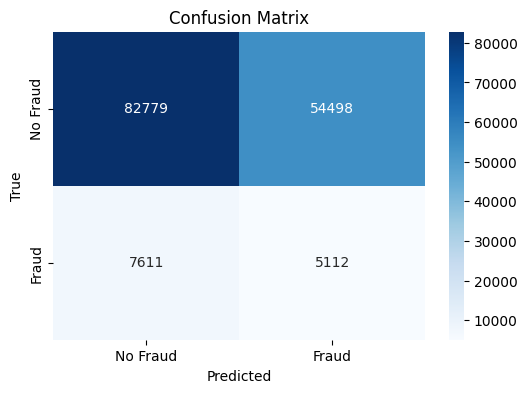

In [246]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Feature Importance (using weight):
{'amount': 156.0, 'channel': 29.0, 'device': 23.0, 'session_length_seconds': 290.0, 'is_first_time_merchant': 12.0, 'age': 164.0, 'education': 44.0, 'primary_source_of_income': 38.0, 'sum_of_monthly_installments': 197.0, 'sum_of_monthly_expenses': 216.0, 'country_user': 100.0, 'category': 57.0, 'country_merchant': 83.0, 'number_of_alerts_last_6_months': 97.0, 'avg_transaction_amount': 260.0, 'account_age_months': 188.0, 'has_fraud_history': 38.0, 'latitude': 241.0, 'longitude': 234.0, 'hour': 105.0, 'day_of_week': 64.0, 'month': 66.0, 'time_since_last_user_txn': 228.0, 'time_since_last_merchant_txn': 250.0, 'time_since_last_user_merchant': 73.0, 'prev_latitude': 245.0, 'prev_longitude': 316.0, 'distance_from_last_txn_km': 247.0, 'velocity_kmph': 186.0, 'number_unique_devices_last_day': 9.0, 'number_unique_devices_per_month': 26.0, 'number_unique_devices_per_year': 5.0, 'expenses_to_isntallment_ratio': 199.0, 'avg_daily_amount': 144.0, 'percent_change_

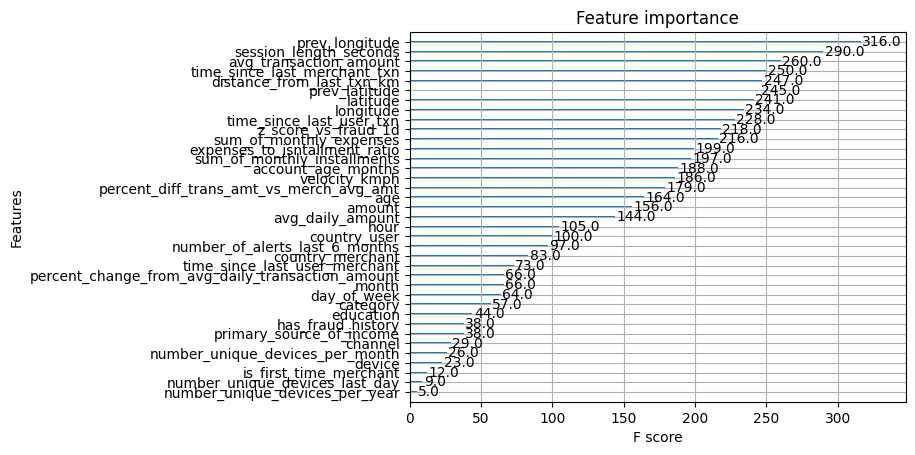

In [296]:
importance = bst.get_score(importance_type='weight')  


print("Feature Importance (using weight):")
print(importance)


xgb.plot_importance(bst, importance_type='weight') 
plt.show()

Feature Importance (using weight):
{'amount': 41.02090835571289, 'channel': 41.82451629638672, 'device': 37.74958419799805, 'session_length_seconds': 42.24553680419922, 'is_first_time_merchant': 38.98259353637695, 'age': 40.80376052856445, 'education': 38.058265686035156, 'primary_source_of_income': 41.353904724121094, 'sum_of_monthly_installments': 43.2872428894043, 'sum_of_monthly_expenses': 43.34296417236328, 'country_user': 43.02555847167969, 'category': 40.33085632324219, 'country_merchant': 42.0731086730957, 'number_of_alerts_last_6_months': 41.9401969909668, 'avg_transaction_amount': 42.70682907104492, 'account_age_months': 42.5601806640625, 'has_fraud_history': 679.759033203125, 'latitude': 45.45549392700195, 'longitude': 43.36288833618164, 'hour': 40.9375, 'day_of_week': 41.916770935058594, 'month': 41.86279296875, 'time_since_last_user_txn': 45.034671783447266, 'time_since_last_merchant_txn': 43.96432876586914, 'time_since_last_user_merchant': 36.90153884887695, 'prev_latitud

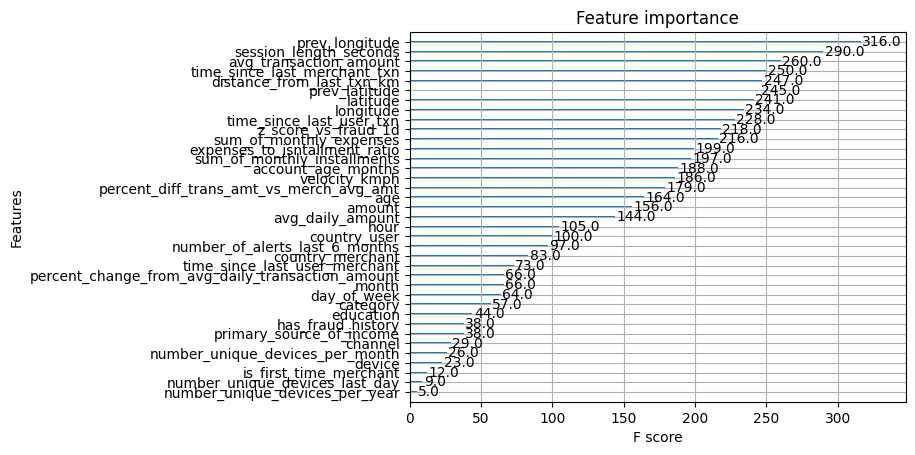

In [297]:
importance = bst.get_score(importance_type='gain')  

print("Feature Importance (using weight):")
print(importance)

xgb.plot_importance(bst, importance_type='weight') 
plt.show()

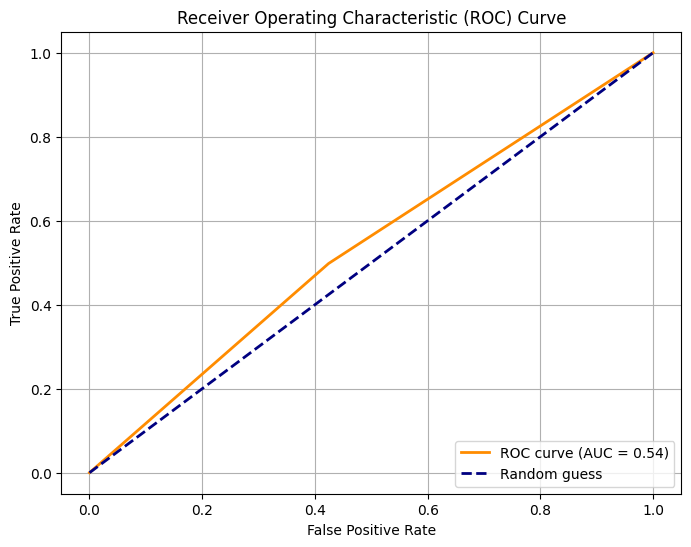

AUC: 0.536936058852513


In [298]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')